In [2]:

import os
import cv2

import random
import numpy as np
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [3]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

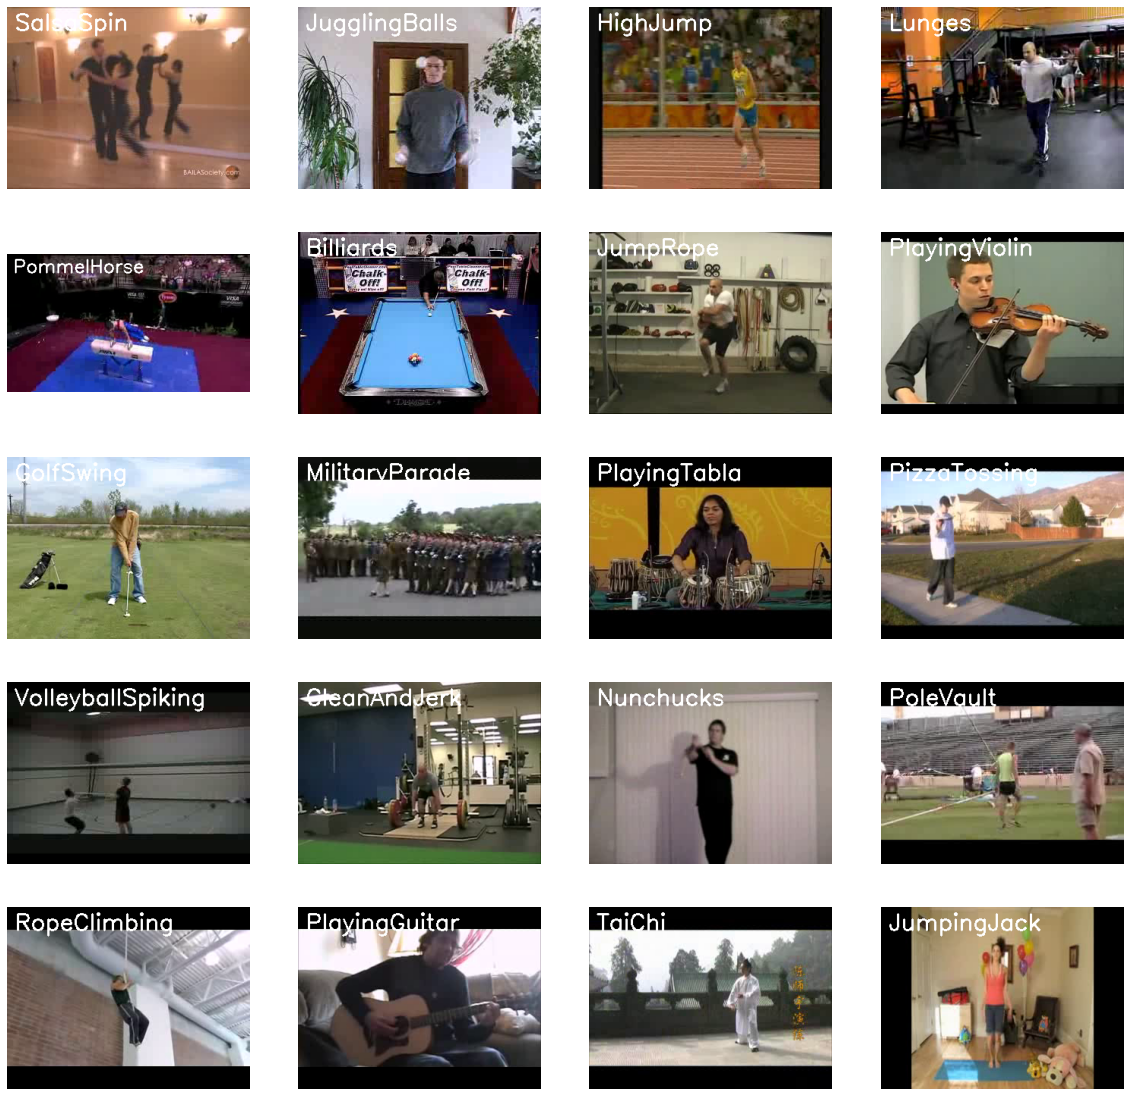

In [4]:

plt.figure(figsize = (20, 20))

all_classes_names = os.listdir('/Users/bipin/Downloads/UCF50')

random_range = random.sample(range(len(all_classes_names)), 20)

for counter, random_index in enumerate(random_range, 1):
    selected_class_Name = all_classes_names[random_index]
    video_files_names_list = os.listdir(f'/Users/bipin/Downloads/UCF50/{selected_class_Name}')
    selected_video_file_name = random.choice(video_files_names_list)
    video_reader = cv2.VideoCapture(f'/Users/bipin/Downloads/UCF50/{selected_class_Name}/{selected_video_file_name}')
    
    _, bgr_frame = video_reader.read()

    video_reader.release()

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [5]:

IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

SEQUENCE_LENGTH = 25

DATASET_DIR = "/Users/bipin/Downloads/UCF50"

CLASSES_LIST = ["BaseballPitch","Basketball","JavelinThrow","JumpRope","MilitaryParade",]

In [6]:
def frames_extraction(video_path):
 
    frames_list = []
   
    video_reader = cv2.VideoCapture(video_path)

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

   
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read() 

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        normalized_frame = resized_frame / 255

        frames_list.append(normalized_frame)

    video_reader.release()

    return frames_list

In [7]:
def create_dataset():
    
    features = []
    labels = []
    video_files_paths = []
    
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        print(f'Extracting Data of Class: {class_name}')
        
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        for file_name in files_list:
            
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:

                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)  
    return features, labels, video_files_paths

In [8]:

features, labels, video_files_paths = create_dataset()

Extracting Data of Class: BaseballPitch
Extracting Data of Class: Basketball
Extracting Data of Class: JavelinThrow
Extracting Data of Class: JumpRope
Extracting Data of Class: MilitaryParade


In [9]:

one_hot_encoded_labels = to_categorical(labels)

In [10]:

features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [11]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
   
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

In [12]:
def create_LRCN_model():
   

    model = Sequential()
    
  
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
   
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    model.summary()
    return model

In [13]:

LRCN_model = create_LRCN_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 25, 64, 64, 16)    448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 25, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 25, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 25, 16, 16, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 25, 4, 4, 32)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 25, 4, 4, 32)      0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 25, 4, 4, 64)      1

In [14]:

early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 20, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/20
102/102 [==============================] - 17s 132ms/step - loss: 1.6196 - accuracy: 0.2236 - val_loss: 1.6078 - val_accuracy: 0.2941
Epoch 2/20
102/102 [==============================] - 11s 108ms/step - loss: 1.5950 - accuracy: 0.2531 - val_loss: 1.5599 - val_accuracy: 0.4706
Epoch 3/20
102/102 [==============================] - 11s 103ms/step - loss: 1.4295 - accuracy: 0.4152 - val_loss: 1.3509 - val_accuracy: 0.4020
Epoch 4/20
102/102 [==============================] - 11s 109ms/step - loss: 1.1786 - accuracy: 0.5160 - val_loss: 1.1893 - val_accuracy: 0.5098
Epoch 5/20
102/102 [==============================] - 11s 108ms/step - loss: 1.0453 - accuracy: 0.5823 - val_loss: 1.3597 - val_accuracy: 0.4216
Epoch 6/20
102/102 [==============================] - 11s 105ms/step - loss: 0.8985 - accuracy: 0.6265 - val_loss: 0.8630 - val_accuracy: 0.6471
Epoch 7/20
102/102 [==============================] - 12s 116ms/step - loss: 0.8231 - accuracy: 0.6953 - val_loss: 0.7104 - val_ac

In [15]:

model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

6/6 [==============================] - 2s 185ms/step - loss: 0.5833 - accuracy: 0.7765


In [16]:

model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history


    
model_file_name = 'sammodell.h5'

LRCN_model.save(model_file_name)

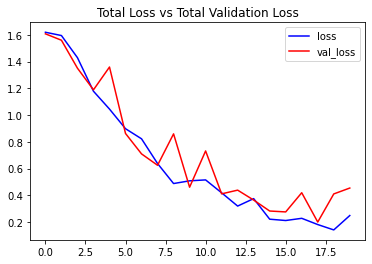

In [17]:

plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

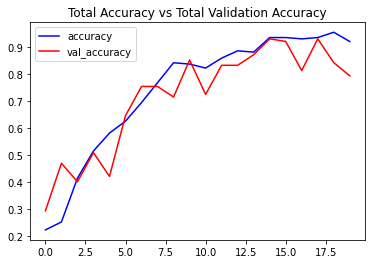

In [18]:

plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [19]:
path="/Users/bipin/Downloads/bbpit.mov"
cap = cv2.VideoCapture(path)
 
# Check if camera opened successfully
if (cap.isOpened()== False):
    print("Error opening video file")
 
# Read until video is completed
while(cap.isOpened()):
     
# Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
    # Display the resulting frame
        cv2.imshow('Frame', frame)
         
    # Press Q on keyboard to exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
 
# Break the loop
    else:
        break
frames = frames_extraction(path)
f=[]
if len(frames) == SEQUENCE_LENGTH:
    f.append(frames)
f = np.asarray(f)
CLASSES_LIST[np.argmax(LRCN_model.predict(f))]

'BaseballPitch'